In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import time, copy
import pandas as pd
import numpy as np
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms

from utils import *
from mobilenet import*

In [5]:
set_seed(1) #for reproductivity

a = 1  # width multiplier[1, 0.75, 0.5, 0.25]
p = 1  # resolution multiplier [1, 2/3, 1/3]

os.environ["CUDA_VISIBLE_DEVICES"] = '7'


In [30]:
# Load dataset

# Resize image using resolution multiplier
transform_train = transforms.Compose([
    transforms.Resize(int(32*p)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.CIFAR10(root='~/data', train = True, download = True, transform = transform_train)

# randomly split train and val
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))
np.random.shuffle(indices)

train_idx, val_idx = indices[split:], indices[:split]

train_sampler = data.sampler.SubsetRandomSampler(train_idx)
val_sampler = data.sampler.SubsetRandomSampler(val_idx)

lengths = [len(train_sampler), len(val_sampler)]

# load
train_loader = data.DataLoader(train_data, sampler=train_sampler, batch_size=512, num_workers = 2)
val_loader = data.DataLoader(train_data, sampler=val_sampler, batch_size=512, num_workers = 2)

# cifar10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  #cifar10 classes

Files already downloaded and verified


In [7]:
def train_model(model, device, train_loader, val_loader, lengths, num_epochs=50):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-10)
    
    if device == 'cuda':
        model.to(device)
        cudnn.benchmark = True
        criterion = criterion.cuda()
    
    since = time.time()
    ACC = {'train' : [], 'val' : []}
    LOSS = {'train' : [], 'val' : []}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        train_loss, train_acc = train(model, device, train_loader, lengths[0], criterion, optimizer)
        LOSS['train'].append(train_loss)
        ACC['train'].append(train_acc)
        
        # evaluate on validation set
        val_loss, val_acc, epoch_model = validate(model, device, val_loader, lengths[1], criterion)
        LOSS['val'].append(val_loss)
        ACC['val'].append(val_acc)
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        #scheduler.step(float(val_loss))    
        print()
    
    print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    print(model.load_state_dict(best_model_wts))
    return best_model_wts, ACC, LOSS


# 1. Mobile Net

In [31]:
LOSS, ACC = {}, {}

net1 = MobileNet(a, p)
net1.apply(weight_reset)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

mobile_best, ACC, LOSS = train_model(net1, device, train_loader, val_loader, lengths, num_epochs=100)

SaveDict(mobile_best, 'mobile_best')
SaveDict(ACC, 'ACC_mobile')
SaveDict(LOSS, 'LOSS_mobile')

Epoch 0/99
----------
LR: 0.0005
Train Loss: 2.1015 Acc: 0.2858 
Val Loss: 2.0245 Acc: 0.3400

Epoch 1/99
----------
LR: 0.0005
Train Loss: 1.6859 Acc: 0.3972 
Val Loss: 2.3963 Acc: 0.3652

Epoch 2/99
----------
LR: 0.0005
Train Loss: 1.4671 Acc: 0.4708 
Val Loss: 1.7637 Acc: 0.4580

Epoch 3/99
----------
LR: 0.0005
Train Loss: 1.3458 Acc: 0.5223 
Val Loss: 1.4521 Acc: 0.5005

Epoch 4/99
----------
LR: 0.0005
Train Loss: 1.3446 Acc: 0.5220 
Val Loss: 1.5066 Acc: 0.4792

Epoch 5/99
----------
LR: 0.0005
Train Loss: 1.4005 Acc: 0.4942 
Val Loss: 1.3813 Acc: 0.5142

Epoch 6/99
----------
LR: 0.0005
Train Loss: 1.2144 Acc: 0.5655 
Val Loss: 1.1885 Acc: 0.5840

Epoch 7/99
----------
LR: 0.0005
Train Loss: 1.0610 Acc: 0.6246 
Val Loss: 1.3715 Acc: 0.5428

Epoch 8/99
----------
LR: 0.0005
Train Loss: 0.9884 Acc: 0.6517 
Val Loss: 1.2116 Acc: 0.5899

Epoch 9/99
----------
LR: 0.0005
Train Loss: 0.8959 Acc: 0.6836 
Val Loss: 1.3107 Acc: 0.5727

Epoch 10/99
----------
LR: 0.0005
Train Loss: 0.83

Val Loss: 1.5570 Acc: 0.7189

Epoch 86/99
----------
LR: 0.0005
Train Loss: 0.0446 Acc: 0.9848 
Val Loss: 1.5635 Acc: 0.7257

Epoch 87/99
----------
LR: 0.0005
Train Loss: 0.0510 Acc: 0.9823 
Val Loss: 1.5676 Acc: 0.7247

Epoch 88/99
----------
LR: 0.0005
Train Loss: 0.0392 Acc: 0.9871 
Val Loss: 1.7252 Acc: 0.7062

Epoch 89/99
----------
LR: 0.0005
Train Loss: 0.1145 Acc: 0.9643 
Val Loss: 1.3871 Acc: 0.7299

Epoch 90/99
----------
LR: 0.0005
Train Loss: 0.0261 Acc: 0.9918 
Val Loss: 1.7081 Acc: 0.7245

Epoch 91/99
----------
LR: 0.0005
Train Loss: 0.0290 Acc: 0.9904 
Val Loss: 1.7156 Acc: 0.7199

Epoch 92/99
----------
LR: 0.0005
Train Loss: 0.0369 Acc: 0.9872 
Val Loss: 1.6079 Acc: 0.7232

Epoch 93/99
----------
LR: 0.0005
Train Loss: 0.0436 Acc: 0.9858 
Val Loss: 1.5799 Acc: 0.7237

Epoch 94/99
----------
LR: 0.0005
Train Loss: 0.0473 Acc: 0.9837 
Val Loss: 1.5588 Acc: 0.7271

Epoch 95/99
----------
LR: 0.0005
Train Loss: 0.0364 Acc: 0.9879 
Val Loss: 1.5280 Acc: 0.7313

Epoch 96/9

0

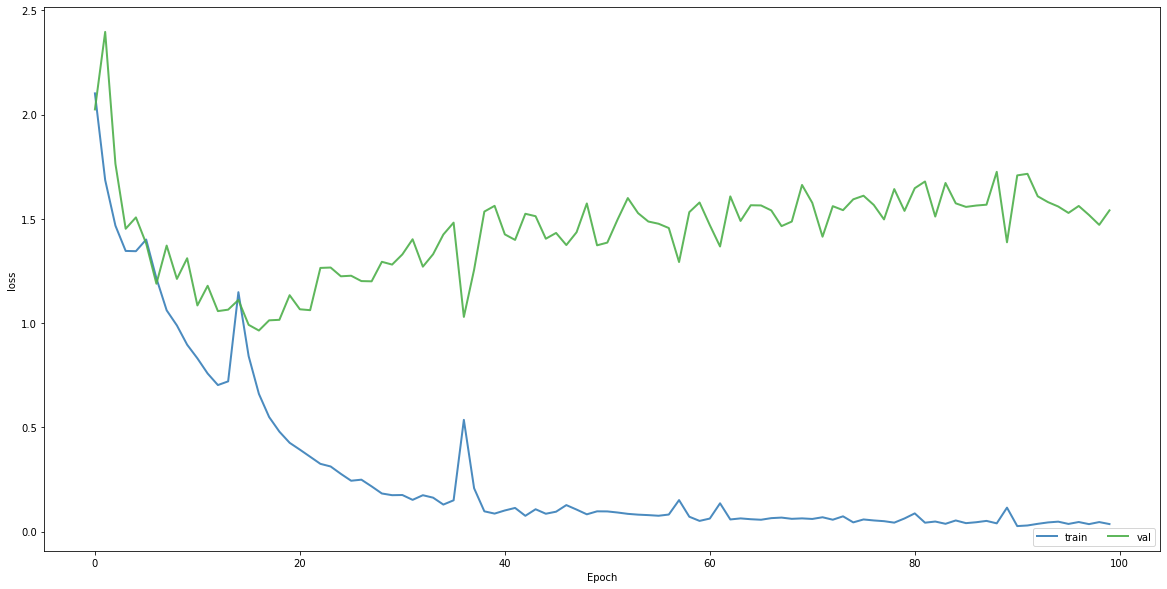

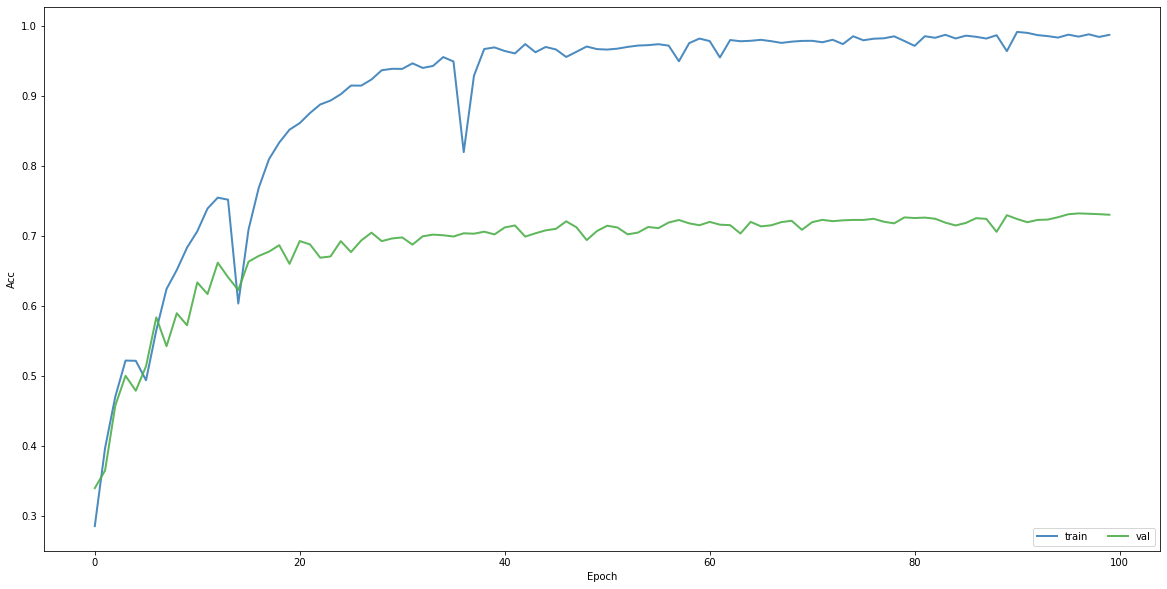

In [32]:
### plot learning curv ###
plotCurve(LOSS, typ ='loss')
plotCurve(ACC, typ ='Acc')

# 2. Conv Mobile Net

In [9]:
### Conv MobileNet ###

LOSS2, ACC2 = {}, {}

net2 = convMN()
net2.apply(weight_reset)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

conv_best, ACC2, LOSS2 = train_model(net2, device, train_loader, val_loader, lengths, num_epochs=100)

SaveDict(conv_best, 'conv_best')
SaveDict(ACC2, 'ACC_conv')
SaveDict(LOSS2, 'LOSS_conv')

Epoch 0/99
----------
LR: 0.0005
Train Loss: 2.3210 Acc: 0.1800 
Val Loss: 4.2594 Acc: 0.1036

Epoch 1/99
----------
LR: 0.0005
Train Loss: 1.9497 Acc: 0.2392 
Val Loss: 1.8989 Acc: 0.2735

Epoch 2/99
----------
LR: 0.0005
Train Loss: 1.8273 Acc: 0.2998 
Val Loss: 1.8335 Acc: 0.3031

Epoch 3/99
----------
LR: 0.0005
Train Loss: 1.6767 Acc: 0.3667 
Val Loss: 1.7297 Acc: 0.3325

Epoch 4/99
----------
LR: 0.0005
Train Loss: 1.4946 Acc: 0.4410 
Val Loss: 1.7493 Acc: 0.4023

Epoch 5/99
----------
LR: 0.0005
Train Loss: 1.4374 Acc: 0.4660 
Val Loss: 1.7900 Acc: 0.4209

Epoch 6/99
----------
LR: 0.0005
Train Loss: 1.3213 Acc: 0.5124 
Val Loss: 1.2678 Acc: 0.5435

Epoch 7/99
----------
LR: 0.0005
Train Loss: 1.1756 Acc: 0.5715 
Val Loss: 1.7240 Acc: 0.4698

Epoch 8/99
----------
LR: 0.0005
Train Loss: 1.1687 Acc: 0.5764 
Val Loss: 1.2370 Acc: 0.5608

Epoch 9/99
----------
LR: 0.0005
Train Loss: 1.0078 Acc: 0.6334 
Val Loss: 1.2952 Acc: 0.5621

Epoch 10/99
----------
LR: 0.0005
Train Loss: 0.89

Val Loss: 1.8578 Acc: 0.7315

Epoch 86/99
----------
LR: 0.0005
Train Loss: 0.0170 Acc: 0.9948 
Val Loss: 1.8823 Acc: 0.7333

Epoch 87/99
----------
LR: 0.0005
Train Loss: 0.0146 Acc: 0.9960 
Val Loss: 2.0002 Acc: 0.7258

Epoch 88/99
----------
LR: 0.0005
Train Loss: 0.0218 Acc: 0.9943 
Val Loss: 1.9403 Acc: 0.7204

Epoch 89/99
----------
LR: 0.0005
Train Loss: 0.0127 Acc: 0.9958 
Val Loss: 2.2108 Acc: 0.7265

Epoch 90/99
----------
LR: 0.0005
Train Loss: 0.0273 Acc: 0.9920 
Val Loss: 1.8551 Acc: 0.7357

Epoch 91/99
----------
LR: 0.0005
Train Loss: 0.0218 Acc: 0.9937 
Val Loss: 1.7967 Acc: 0.7376

Epoch 92/99
----------
LR: 0.0005
Train Loss: 0.0121 Acc: 0.9963 
Val Loss: 2.0024 Acc: 0.7307

Epoch 93/99
----------
LR: 0.0005
Train Loss: 0.0198 Acc: 0.9939 
Val Loss: 1.8583 Acc: 0.7399

Epoch 94/99
----------
LR: 0.0005
Train Loss: 0.0344 Acc: 0.9914 
Val Loss: 1.8800 Acc: 0.7202

Epoch 95/99
----------
LR: 0.0005
Train Loss: 0.0245 Acc: 0.9933 
Val Loss: 1.9089 Acc: 0.7286

Epoch 96/9

NameError: name 'conv_vest' is not defined

In [10]:
SaveDict(conv_best, 'conv_best')
SaveDict(ACC2, 'ACC_conv')
SaveDict(LOSS2, 'LOSS_conv')

0

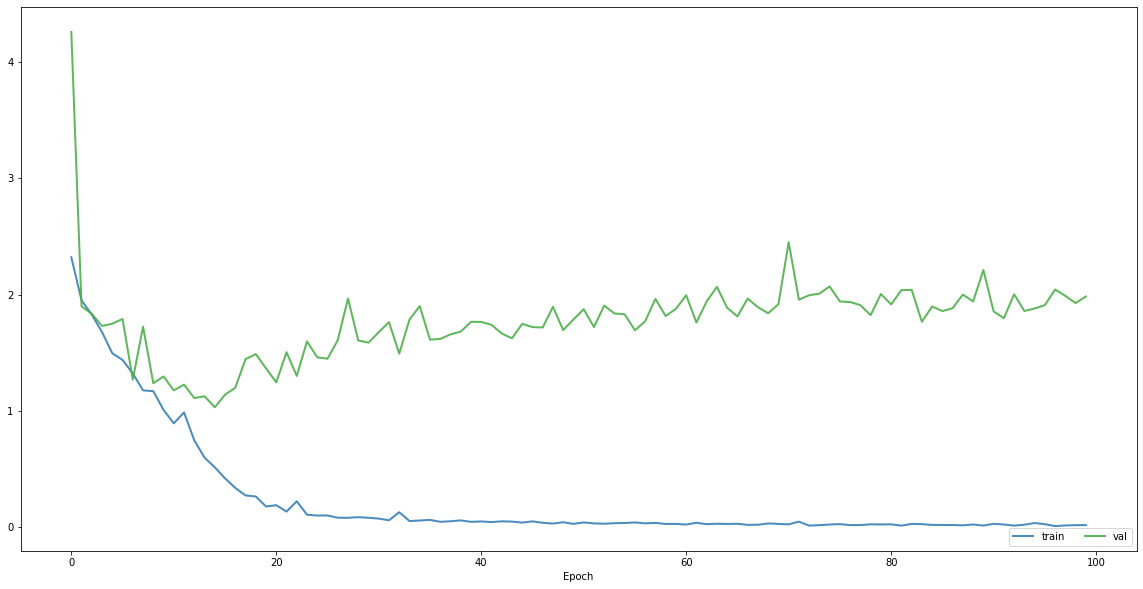

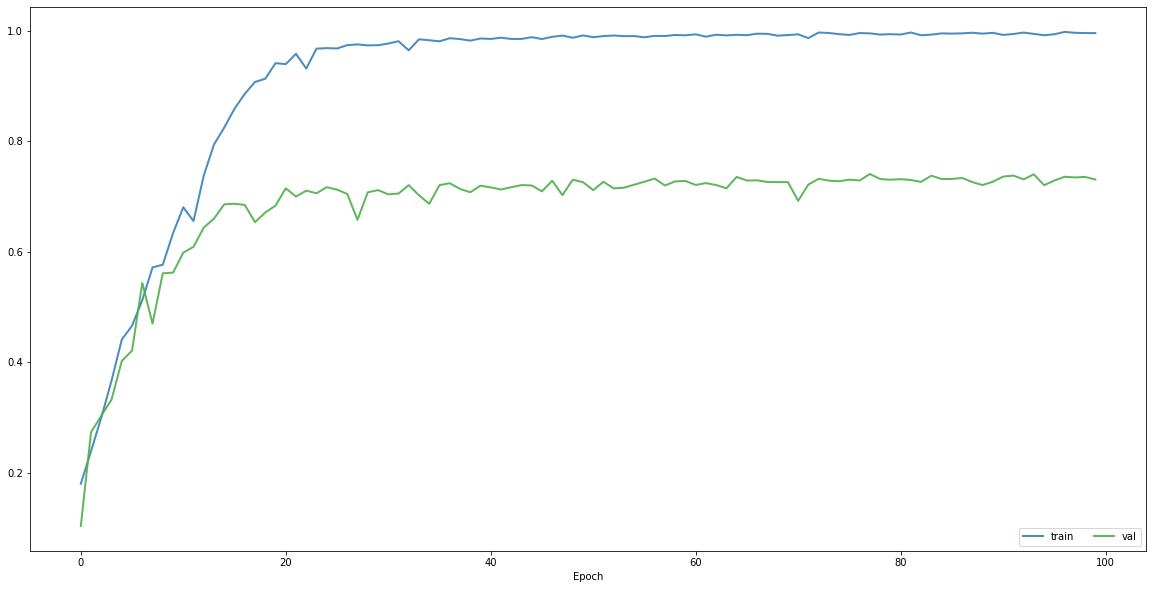

In [11]:
### plot learning curv ###
plotCurve(LOSS2, typ ='loss')
plotCurve(ACC2, typ ='Acc')

# 3. Narrow MobileNet (0.75 MobileNet)

In [8]:
### Conv MobileNet ###

LOSS3, ACC3 = {}, {}

net3 = MobileNet(a = 0.75, p = 1)
net3.apply(weight_reset)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

narr_best, ACC3, LOSS3 = train_model(net3, device, train_loader, val_loader, lengths, num_epochs=100)

SaveDict(narr_best, 'narr_best')
SaveDict(ACC3, 'ACC_narr')
SaveDict(LOSS3, 'LOSS_narr')

Epoch 0/99
----------
LR: 0.0005
Train Loss: 2.0152 Acc: 0.2856 
Val Loss: 2.0022 Acc: 0.3510

Epoch 1/99
----------
LR: 0.0005
Train Loss: 1.5812 Acc: 0.4231 
Val Loss: 1.6534 Acc: 0.4293

Epoch 2/99
----------
LR: 0.0005
Train Loss: 1.4268 Acc: 0.4803 
Val Loss: 1.5508 Acc: 0.4717

Epoch 3/99
----------
LR: 0.0005
Train Loss: 1.3795 Acc: 0.5020 
Val Loss: 1.4493 Acc: 0.4931

Epoch 4/99
----------
LR: 0.0005
Train Loss: 1.3092 Acc: 0.5334 
Val Loss: 1.4248 Acc: 0.5166

Epoch 5/99
----------
LR: 0.0005
Train Loss: 1.1560 Acc: 0.5885 
Val Loss: 1.3050 Acc: 0.5462

Epoch 6/99
----------
LR: 0.0005
Train Loss: 1.0636 Acc: 0.6243 
Val Loss: 1.3673 Acc: 0.5689

Epoch 7/99
----------
LR: 0.0005
Train Loss: 1.0985 Acc: 0.6164 
Val Loss: 1.1456 Acc: 0.6055

Epoch 8/99
----------
LR: 0.0005
Train Loss: 0.9878 Acc: 0.6591 
Val Loss: 1.0609 Acc: 0.6311

Epoch 9/99
----------
LR: 0.0005
Train Loss: 0.8707 Acc: 0.6959 
Val Loss: 1.1770 Acc: 0.6094

Epoch 10/99
----------
LR: 0.0005
Train Loss: 0.94

Val Loss: 1.8094 Acc: 0.7086

Epoch 86/99
----------
LR: 0.0005
Train Loss: 0.0663 Acc: 0.9773 
Val Loss: 1.6226 Acc: 0.7067

Epoch 87/99
----------
LR: 0.0005
Train Loss: 0.0524 Acc: 0.9820 
Val Loss: 1.6983 Acc: 0.7163

Epoch 88/99
----------
LR: 0.0005
Train Loss: 0.0400 Acc: 0.9860 
Val Loss: 1.8120 Acc: 0.7030

Epoch 89/99
----------
LR: 0.0005
Train Loss: 0.0489 Acc: 0.9830 
Val Loss: 1.7477 Acc: 0.7027

Epoch 90/99
----------
LR: 0.0005
Train Loss: 0.0652 Acc: 0.9774 
Val Loss: 1.6424 Acc: 0.7099

Epoch 91/99
----------
LR: 0.0005
Train Loss: 0.0384 Acc: 0.9873 
Val Loss: 1.7214 Acc: 0.7065

Epoch 92/99
----------
LR: 0.0005
Train Loss: 0.0366 Acc: 0.9871 
Val Loss: 1.7718 Acc: 0.7019

Epoch 93/99
----------
LR: 0.0005
Train Loss: 0.0457 Acc: 0.9842 
Val Loss: 1.7884 Acc: 0.7110

Epoch 94/99
----------
LR: 0.0005
Train Loss: 0.0489 Acc: 0.9832 
Val Loss: 1.7553 Acc: 0.7109

Epoch 95/99
----------
LR: 0.0005
Train Loss: 0.0425 Acc: 0.9854 
Val Loss: 1.8126 Acc: 0.7045

Epoch 96/9

0

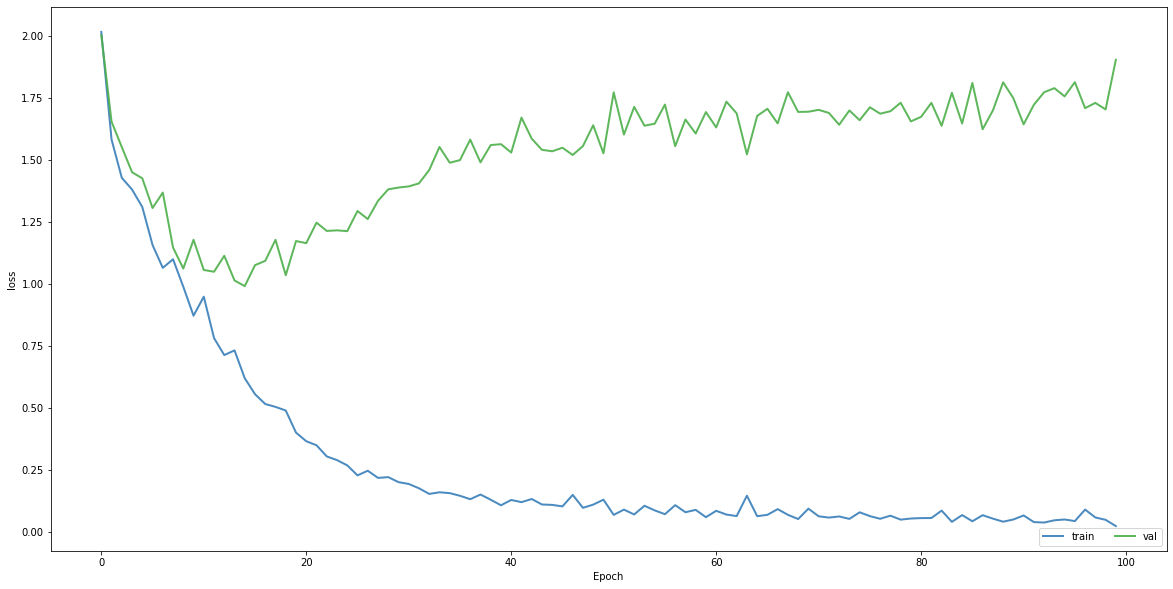

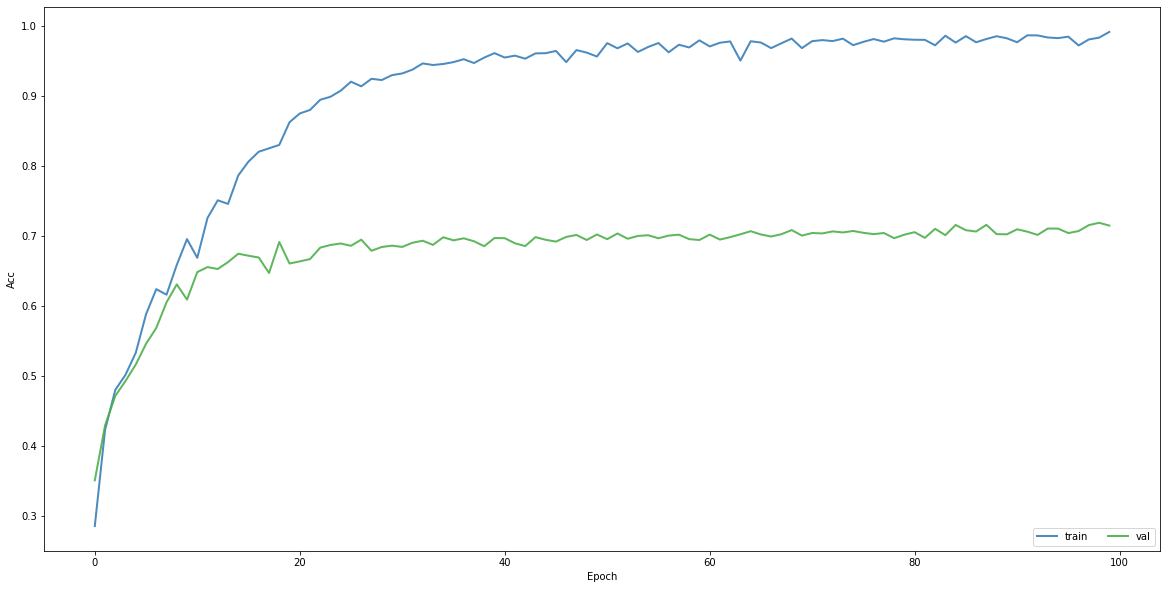

In [9]:
### plot learning curv ###
plotCurve(LOSS3, typ ='loss')
plotCurve(ACC3, typ ='Acc')

# 4. shallow MobileNet

In [25]:
### Conv MobileNet ###

LOSS4, ACC4 = {}, {}

net4 = MobileNet_shall(a = 1, p = 1)
net4.apply(weight_reset)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

shall_best, ACC4, LOSS4 = train_model(net4, device, train_loader, val_loader, lengths, num_epochs=100)

SaveDict(shall_best, 'shall_best')
SaveDict(ACC4, 'ACC_shall')
SaveDict(LOSS4, 'LOSS_shall')

Epoch 0/99
----------
LR: 0.0005
Train Loss: 1.9689 Acc: 0.3360 
Val Loss: 1.5175 Acc: 0.4510

Epoch 1/99
----------
LR: 0.0005
Train Loss: 1.3982 Acc: 0.4934 
Val Loss: 1.4006 Acc: 0.4922

Epoch 2/99
----------
LR: 0.0005
Train Loss: 1.2341 Acc: 0.5557 
Val Loss: 1.3440 Acc: 0.5326

Epoch 3/99
----------
LR: 0.0005
Train Loss: 1.1346 Acc: 0.5995 
Val Loss: 1.2505 Acc: 0.5597

Epoch 4/99
----------
LR: 0.0005
Train Loss: 1.0260 Acc: 0.6356 
Val Loss: 1.2574 Acc: 0.5561

Epoch 5/99
----------
LR: 0.0005
Train Loss: 0.9962 Acc: 0.6497 
Val Loss: 1.2432 Acc: 0.5885

Epoch 6/99
----------
LR: 0.0005
Train Loss: 0.8928 Acc: 0.6849 
Val Loss: 1.1360 Acc: 0.6146

Epoch 7/99
----------
LR: 0.0005
Train Loss: 0.8630 Acc: 0.6933 
Val Loss: 1.0318 Acc: 0.6470

Epoch 8/99
----------
LR: 0.0005
Train Loss: 0.7128 Acc: 0.7481 
Val Loss: 1.5548 Acc: 0.6246

Epoch 9/99
----------
LR: 0.0005
Train Loss: 0.6968 Acc: 0.7598 
Val Loss: 1.1407 Acc: 0.6342

Epoch 10/99
----------
LR: 0.0005
Train Loss: 0.60

Val Loss: 2.0642 Acc: 0.7057

Epoch 86/99
----------
LR: 0.0005
Train Loss: 0.0465 Acc: 0.9841 
Val Loss: 1.9883 Acc: 0.7053

Epoch 87/99
----------
LR: 0.0005
Train Loss: 0.0416 Acc: 0.9854 
Val Loss: 1.9047 Acc: 0.7046

Epoch 88/99
----------
LR: 0.0005
Train Loss: 0.0250 Acc: 0.9917 
Val Loss: 2.1299 Acc: 0.7056

Epoch 89/99
----------
LR: 0.0005
Train Loss: 0.0333 Acc: 0.9890 
Val Loss: 2.0972 Acc: 0.7079

Epoch 90/99
----------
LR: 0.0005
Train Loss: 0.0448 Acc: 0.9849 
Val Loss: 2.1337 Acc: 0.6918

Epoch 91/99
----------
LR: 0.0005
Train Loss: 0.0429 Acc: 0.9852 
Val Loss: 2.0354 Acc: 0.7098

Epoch 92/99
----------
LR: 0.0005
Train Loss: 0.0264 Acc: 0.9912 
Val Loss: 2.0818 Acc: 0.7061

Epoch 93/99
----------
LR: 0.0005
Train Loss: 0.0397 Acc: 0.9866 
Val Loss: 1.9543 Acc: 0.7103

Epoch 94/99
----------
LR: 0.0005
Train Loss: 0.0342 Acc: 0.9883 
Val Loss: 1.9876 Acc: 0.7048

Epoch 95/99
----------
LR: 0.0005
Train Loss: 0.0195 Acc: 0.9938 
Val Loss: 2.1135 Acc: 0.7095

Epoch 96/9

0

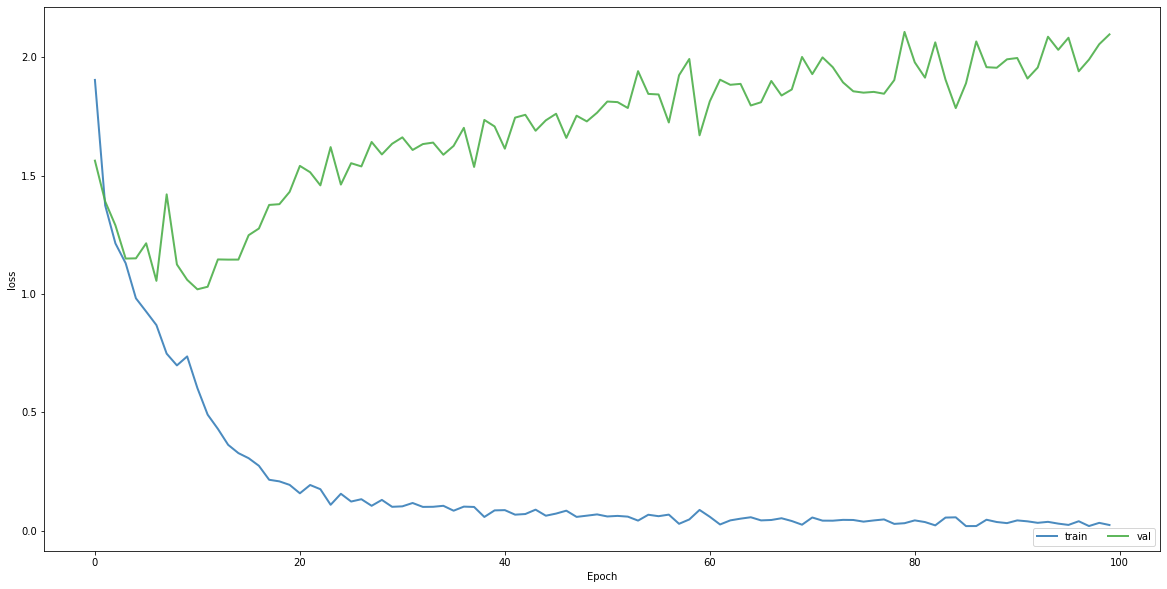

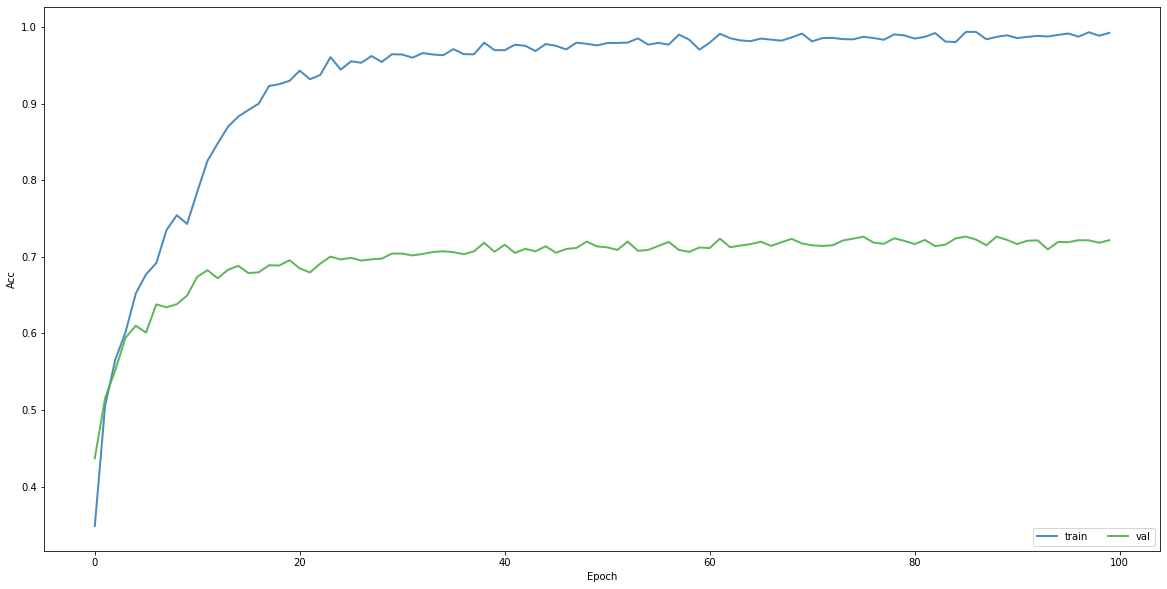

In [23]:
### plot learning curv ###
plotCurve(LOSS4, typ = 'loss')
plotCurve(ACC4, typ = 'Acc')

# Test

In [ ]:
# parameters


In [33]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_data = torchvision.datasets.CIFAR10(root='~/data', train = False, download = True, transform = transform_test)
test_loader = data.DataLoader(test_data, shuffle = True, batch_size=512, num_workers = 2)
length = len(test_data)

net1 = MobileNet(1, 1)
net2 = convMN()
net3 = MobileNet(0.75, 1)
net4 = MobileNet_shall(1, 1)

net1.load_state_dict(LoadDict('mobile_best'), True)
net2.load_state_dict(LoadDict('conv_best'), True)
net3.load_state_dict(LoadDict('narr_best'), True)
net4.load_state_dict(LoadDict('shall_best'), True)

criterion = nn.CrossEntropyLoss().cuda()

_ = validate(net1.to(device), device, test_loader, length, criterion, mode = 'test')
_ = validate(net2.to(device), device, test_loader, length, criterion, mode = 'test')
_ = validate(net3.to(device), device, test_loader, length, criterion, mode = 'test')
_ = validate(net4.to(device), device, test_loader, length, criterion, mode = 'test')


Files already downloaded and verified
Test Loss: 1.6226 Acc: 0.7277
Test Loss: 2.0064 Acc: 0.7342
Test Loss: 1.7371 Acc: 0.7160
Test Loss: 2.1374 Acc: 0.7038
